In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_path = "../data/raw/flextrack-training-data-v0.1.csv"

In [3]:
df_train = pd.read_csv(train_path)

In [4]:
print("Shape:", df_train.shape)
df_train.head()

Shape: (105120, 7)


,Site,Timestamp_Local,Dry_Bulb_Temperature_C,Global_Horizontal_Radiation_W/m2,Building_Power_kW,Demand_Response_Flag,Demand_Response_Capacity_kW
0,siteA,2019-01-01 00:00:00,22.20,0.0,4.8,0,0.0
1,siteA,2019-01-01 00:15:00,22.27,0.0,4.8,0,0.0
2,siteA,2019-01-01 00:30:00,22.35,0.0,4.8,0,0.0
3,siteA,2019-01-01 00:45:00,22.42,0.0,4.8,0,0.0
4,siteA,2019-01-01 01:00:00,22.50,0.0,4.8,0,0.0


In [9]:
# Distribution of flags (global)

print("Class distribution (counts):")
print(df_train["Demand_Response_Flag"].value_counts())
print("\nClass distribution (percentage):")
print(df_train["Demand_Response_Flag"].value_counts(normalize=True) * 100)

Class distribution (counts):
Demand_Response_Flag
 0    102011
-1      2262
 1       847
Name: count, dtype: int64

Class distribution (percentage):
Demand_Response_Flag
 0    97.042428
-1     2.151826
 1     0.805746
Name: proportion, dtype: float64


In [10]:
# Cross-site comparison
print("\nFlag distribution per site:")
print(df_train.groupby("Site")["Demand_Response_Flag"].value_counts().unstack(fill_value=0))


Flag distribution per site:
Demand_Response_Flag   -1      0    1
Site                                 
siteA                 631  34269  140
siteB                 676  33931  433
siteC                 955  33811  274


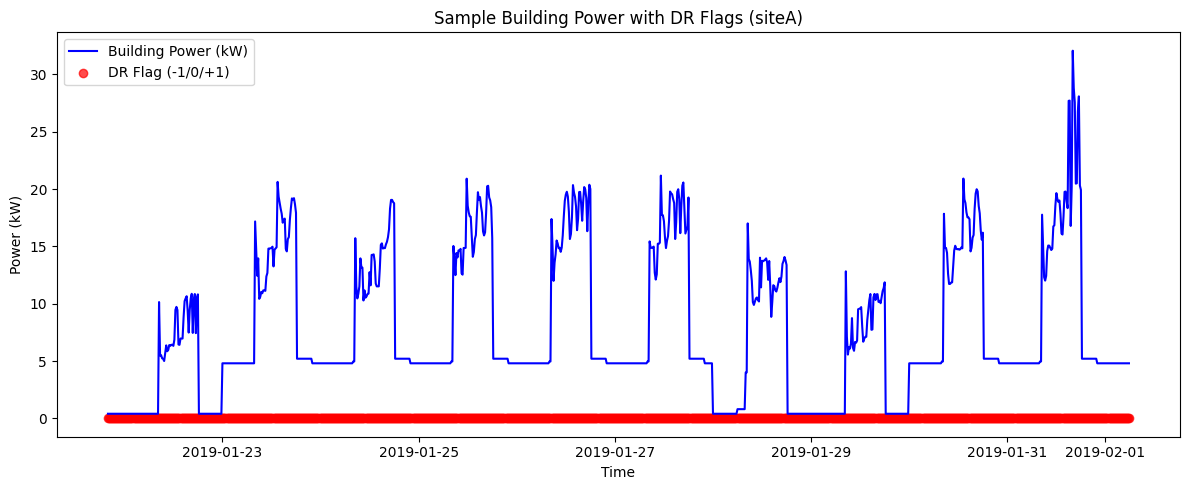

In [23]:
# Visualize an event slice (siteA, rows 2000–3000 as an example)
siteA_sample = df_train[df_train["Site"] == "siteA"].iloc[2000:3000]

plt.figure(figsize=(12, 5))
plt.plot(siteA_sample["Timestamp_Local"], siteA_sample["Building_Power_kW"], label="Building Power (kW)", color="blue")
plt.scatter(siteA_sample["Timestamp_Local"], 
            siteA_sample["Demand_Response_Flag"] * 50,  # scaled for visibility
            color="red", label="DR Flag (-1/0/+1)", alpha=0.7)
plt.title("Sample Building Power with DR Flags (siteA)")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.legend()
plt.tight_layout()
plt.show()

# 📝 Notebook Progress Log

## ✅ Step 1: Load Data
- Loaded `flextrack-2025-training-data-v0.1.csv`
- Confirmed shape: **105,120 rows × 7 columns**
- Previewed first rows with `df_train.head()`
- **Note:** `Timestamp_Local` is still a string (not parsed yet)

## ✅ Step 2: Target Variable Exploration
- Computed global class distribution for `Demand_Response_Flag`:
  - `0` ≈ 97.04%
  - `-1` ≈ 2.15%
  - `+1` ≈ 0.81%
- Computed per-site counts of `Demand_Response_Flag` (`siteA`, `siteB`, `siteC`)

## ✅ Step 3: Quick Visualization
- Plotted a sample slice (`siteA` rows 2000–3000):
  - Blue line: `Building_Power_kW`
  - Red points: `Demand_Response_Flag` (scaled)  
- Purpose: eyeball how rare/subtle DR events are within daily load cycles

## 🎯 Key Takeaways (so far)
- **Severe class imbalance** (events are rare, especially `+1`)
- Events appear **subtle** relative to normal daily variability
- Sites differ in event frequencies → generalization across sites will matter

---

### 🔜 Next Step (planned)
- Parse `Timestamp_Local` to `datetime` and sort by `Site, Timestamp_Local` to enable time-aware validation and feature engineering.


In [12]:

# 1) Parse to datetime
df_train["Timestamp_Local"] = pd.to_datetime(df_train["Timestamp_Local"], errors="raise")

# 2) Sanity checks
print(df_train["Timestamp_Local"].dtype)
print(df_train.groupby("Site")["Timestamp_Local"].agg(["min","max"]).reset_index())

# 3) Sort by site + time (important for time-aware CV later)
df_train = df_train.sort_values(["Site", "Timestamp_Local"]).reset_index(drop=True)


datetime64[ns]
    Site        min                 max
0  siteA 2019-01-01 2019-12-31 23:45:00
1  siteB 2019-01-01 2019-12-31 23:45:00
2  siteC 2023-01-01 2023-12-31 23:45:00


hour
0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.025342
11    0.067352
12    0.092009
13    0.105023
14    0.105023
15    0.105023
16    0.105023
17    0.105023
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
Name: Demand_Response_Flag, dtype: float64


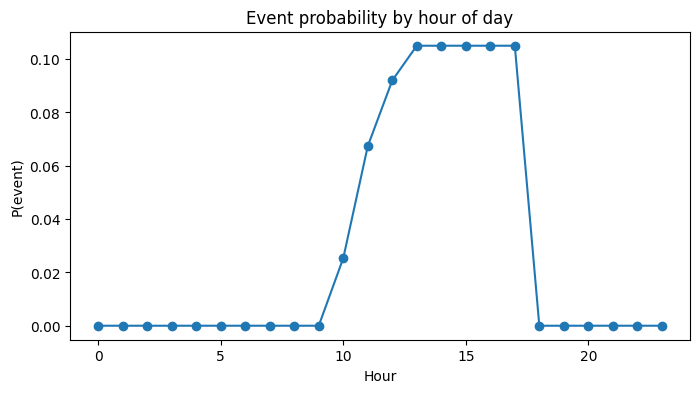

In [14]:
# Event probability by hour of day
df_train["hour"] = df_train["Timestamp_Local"].dt.hour
event_by_hour = df_train.groupby("hour")["Demand_Response_Flag"].apply(lambda x: (x!=0).mean())

print(event_by_hour)

plt.figure(figsize=(8,4))
plt.plot(event_by_hour.index, event_by_hour.values, marker="o")
plt.title("Event probability by hour of day")
plt.xlabel("Hour")
plt.ylabel("P(event)")
plt.show()

## ✅ Step: Event Distribution by Hour of Day
- Calculated probability of DR events across 24 hours
- **Findings:**
  - No events occur before 10:00 or after 17:00
  - Peak event window: **11:00–17:00**
  - Highest event rate ≈ **10.5%** (13:00–17:00)
- **Implication:** Hour of day is a critical predictive feature; models should focus on business hours to avoid false positives.


dow
0    0.029848
1    0.030393
2    0.029180
3    0.025307
4    0.040264
5    0.030449
6    0.021630
Name: Demand_Response_Flag, dtype: float64


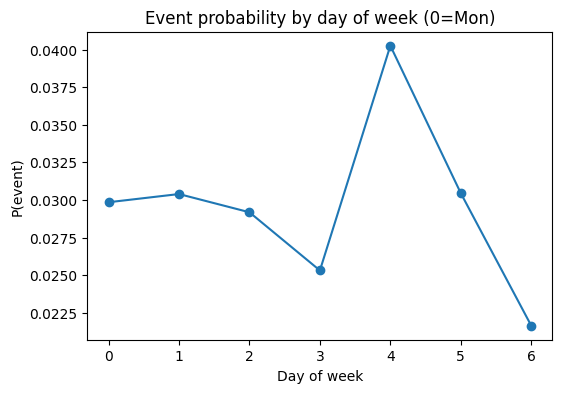

In [15]:
# Event probability by day of week
df_train["dow"] = df_train["Timestamp_Local"].dt.dayofweek
event_by_dow = df_train.groupby("dow")["Demand_Response_Flag"].apply(lambda x: (x!=0).mean())

print(event_by_dow)

plt.figure(figsize=(6,4))
plt.plot(event_by_dow.index, event_by_dow.values, marker="o")
plt.title("Event probability by day of week (0=Mon)")
plt.xlabel("Day of week")
plt.ylabel("P(event)")
plt.show()

## ✅ Step: Event Distribution by Day of Week
- Computed event probability for each day (0=Mon … 6=Sun)
- **Findings:**
  - Events occur consistently on weekdays (~2.5–4.0%)
  - Friday has the highest rate (~4.0%)
  - Weekends, especially Sunday (~2.1%), show fewer events
- **Implication:** Day-of-week is a useful context feature; weekends likely need different treatment from weekdays.

month
1     0.062388
2     0.052083
3     0.000000
4     0.000000
5     0.000000
6     0.053125
7     0.056452
8     0.046259
9     0.000000
10    0.000000
11    0.000000
12    0.084677
Name: Demand_Response_Flag, dtype: float64


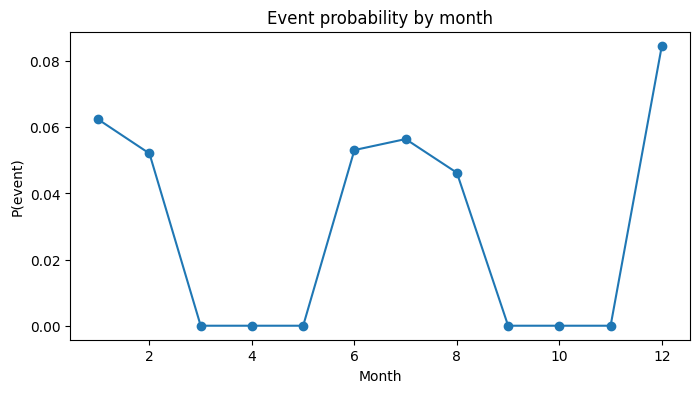

In [16]:
# Event probability by month
df_train["month"] = df_train["Timestamp_Local"].dt.month
event_by_month = df_train.groupby("month")["Demand_Response_Flag"].apply(lambda x: (x!=0).mean())

print(event_by_month)

plt.figure(figsize=(8,4))
plt.plot(event_by_month.index, event_by_month.values, marker="o")
plt.title("Event probability by month")
plt.xlabel("Month")
plt.ylabel("P(event)")
plt.show()

## ✅ Step: Event Distribution by Month
- Computed event probability by month (1=Jan … 12=Dec)
- **Findings:**
  - Events cluster in **Jan–Feb, Jun–Aug, and Dec**
  - No events in Mar–May or Sep–Nov
  - Highest rate: **December (~8.5%)**
- **Implication:** Strong seasonal signal; month/season features will be valuable for detecting events.


Temperature (°C):
                         count       mean       std   min     25%    50%  \
Demand_Response_Flag                                                       
-1                      2262.0  21.145407  6.015800  9.19  16.390  20.45   
 0                    102011.0  17.574401  5.393874  2.40  13.420  17.50   
 1                       847.0  19.556730  6.379061  7.10  13.595  19.00   

                         75%    max  
Demand_Response_Flag                 
-1                    25.315  40.04  
 0                    21.250  43.20  
 1                    24.610  34.00  

Radiation (W/m2):
                         count        mean         std   min     25%    50%  \
Demand_Response_Flag                                                          
-1                      2262.0  665.006189  306.660174  25.0  448.25  626.5   
 0                    102011.0  239.981541  326.267699   0.0    0.00    6.0   
 1                       847.0  656.976387  292.761050  25.0  424.50  635.0 

<Figure size 800x400 with 0 Axes>

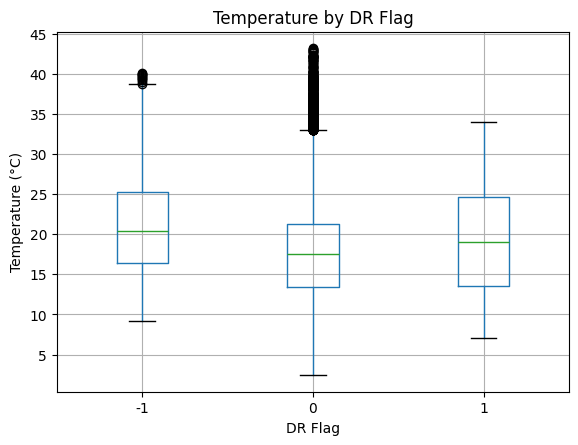

<Figure size 800x400 with 0 Axes>

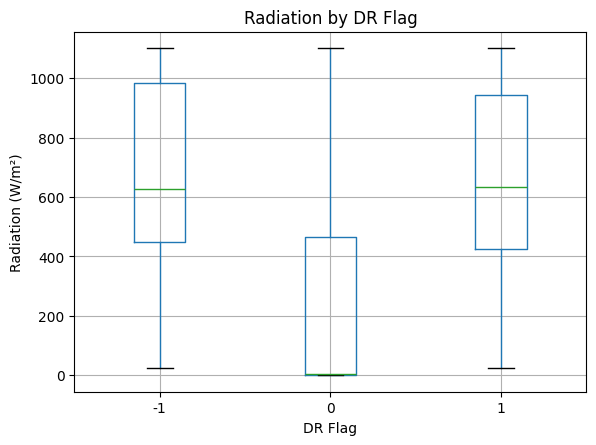

In [17]:
# Separate baseline vs event rows
baseline = df_train[df_train["Demand_Response_Flag"] == 0]
events   = df_train[df_train["Demand_Response_Flag"] != 0]

# Temperature comparison
print("Temperature (°C):")
print(df_train.groupby("Demand_Response_Flag")["Dry_Bulb_Temperature_C"].describe())

# Radiation comparison
print("\nRadiation (W/m2):")
print(df_train.groupby("Demand_Response_Flag")["Global_Horizontal_Radiation_W/m2"].describe())

# Quick visual: temperature
plt.figure(figsize=(8,4))
df_train.boxplot(column="Dry_Bulb_Temperature_C", by="Demand_Response_Flag")
plt.title("Temperature by DR Flag")
plt.suptitle("")
plt.xlabel("DR Flag")
plt.ylabel("Temperature (°C)")
plt.show()

# Quick visual: radiation
plt.figure(figsize=(8,4))
df_train.boxplot(column="Global_Horizontal_Radiation_W/m2", by="Demand_Response_Flag")
plt.title("Radiation by DR Flag")
plt.suptitle("")
plt.xlabel("DR Flag")
plt.ylabel("Radiation (W/m²)")
plt.show()


## ✅ Step: Weather Context During Events
- Compared distributions of temperature and radiation by DR flag
- **Findings:**
  - Events occur in **warmer conditions** (avg ~19–21 °C vs 17.6 °C baseline)
  - Events strongly tied to **daytime with high solar radiation** (~600 W/m²)
- **Implication:** Temperature and radiation are critical predictors; DR events are concentrated in hot, sunny periods.


In [20]:
# Calculate event durations (continuous runs of -1 or +1 flags)

durations = []

for site, df_site in df_train.groupby("Site"):
    flag_series = df_site["Demand_Response_Flag"].reset_index(drop=True)
    current_flag, length = 0, 0
    
    for flag in flag_series:
        if flag == current_flag and flag != 0:
            length += 1
        else:
            if current_flag != 0:  # event ended
                durations.append({"Site": site, "Flag": current_flag, "Length": length})
            current_flag = flag
            length = 1 if flag != 0 else 0
    
    # catch last event
    if current_flag != 0:
        durations.append({"Site": site, "Flag": current_flag, "Length": length})

df_durations = pd.DataFrame(durations)
df_durations["Hours"] = df_durations["Length"] * 0.25  # 15 min steps


# Summary stats
print(df_durations.groupby("Flag")["Hours"].describe())

      count      mean       std  min   25%   50%  75%  max
Flag                                                      
-1     94.0  6.015957  0.355087  5.0  6.00  6.00  6.0  7.0
 1     79.0  2.680380  2.067738  1.0  1.25  1.75  5.0  7.0


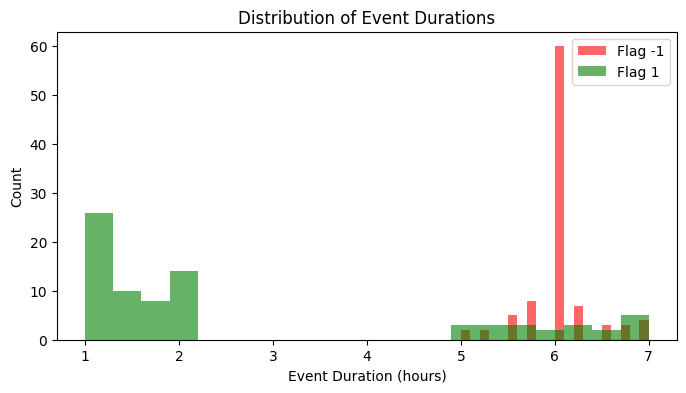

In [21]:
plt.figure(figsize=(8,4))
for flag, color in [(-1,"red"), (1,"green")]:
    subset = df_durations[df_durations["Flag"]==flag]
    plt.hist(subset["Hours"], bins=20, alpha=0.6, label=f"Flag {flag}", color=color)
plt.xlabel("Event Duration (hours)")
plt.ylabel("Count")
plt.title("Distribution of Event Durations")
plt.legend()
plt.show()

## ✅ Step: Event Duration Analysis
- Measured continuous event lengths (15-min resolution)
- **Findings:**
  - -1 events: almost always **~6 hours** (very consistent)
  - +1 events: shorter, avg ~2.7h, more variable (1–7h)
- **Implication:**
  - Models must capture **multi-hour load patterns**
  - Rolling features (1h, 3h, 6h) and persistence signals will be critical


Capacity summary (all events):
count    3109.000000
mean       -2.763049
std        25.615778
min      -129.420000
25%        -4.400000
50%        -0.270000
75%         1.120000
90%         7.696000
95%        35.034000
max       148.020000
Name: Demand_Response_Capacity_kW, dtype: float64

Capacity summary by flag:
                       count       mean        std     min    25%   50%   75%  \
Demand_Response_Flag                                                            
-1                    2262.0  -9.134045  21.882348 -129.42 -7.235 -2.88  0.00   
 1                     847.0  14.251346  27.065027  -54.37  0.850  4.05  8.67   

                         max  
Demand_Response_Flag          
-1                     66.72  
 1                    148.02  


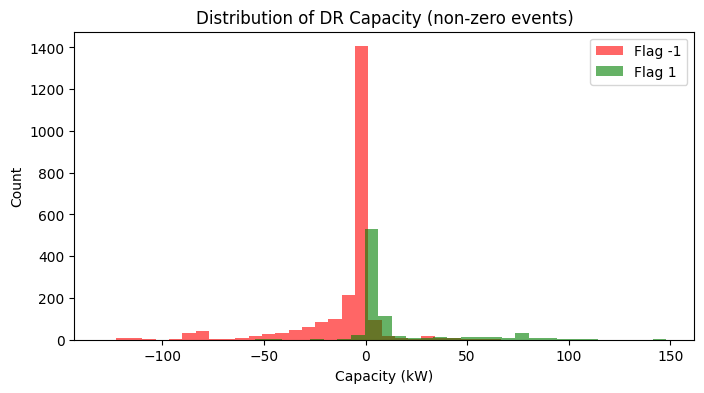

In [22]:
# Only non-zero events matter
df_events = df_train[df_train["Demand_Response_Flag"] != 0]

print("Capacity summary (all events):")
print(df_events["Demand_Response_Capacity_kW"].describe(percentiles=[0.25,0.5,0.75,0.9,0.95]))

# Split by -1 vs +1
print("\nCapacity summary by flag:")
print(df_events.groupby("Demand_Response_Flag")["Demand_Response_Capacity_kW"].describe())

# Histogram
plt.figure(figsize=(8,4))
for flag, color in [(-1,"red"), (1,"green")]:
    subset = df_events[df_events["Demand_Response_Flag"]==flag]
    plt.hist(subset["Demand_Response_Capacity_kW"], bins=30, alpha=0.6, label=f"Flag {flag}", color=color)
plt.xlabel("Capacity (kW)")
plt.ylabel("Count")
plt.title("Distribution of DR Capacity (non-zero events)")
plt.legend()
plt.show()

## ✅ Step: Capacity Distribution Analysis
- Explored `Demand_Response_Capacity_kW` for non-zero events
- **Findings:**
  - Distribution is skewed with many small events and a few very large outliers
  - -1 events: mean ≈ -9.1 kW (down to -129 kW)
  - +1 events: mean ≈ +14.3 kW (up to +148 kW)
- **Implication:**
  - Regression will need robust methods (log-transform, Huber/quantile loss)
  - Correct flag prediction is critical; otherwise regression output is irrelevant


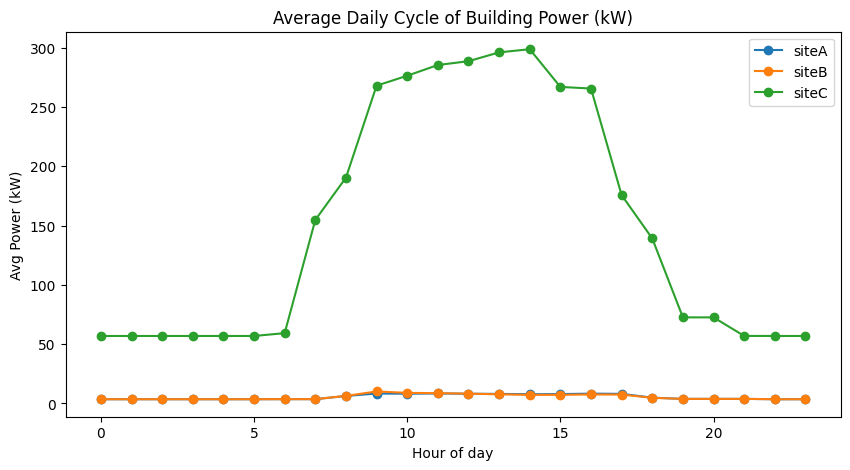

Lag correlations with Building_Power_kW (siteA):
Dry_Bulb_Temperature_C              0.325044
Global_Horizontal_Radiation_W/m2    0.567247
Demand_Response_Flag                0.001143
Demand_Response_Capacity_kW         0.090011
hour                                0.103807
dow                                 0.388768
month                              -0.125993
lag_1                               0.944401
lag_4                               0.831341
lag_12                              0.573991
lag_24                              0.236014
Name: Building_Power_kW, dtype: float64


In [24]:
# 1) Average daily cycle per site
df_train["hour"] = df_train["Timestamp_Local"].dt.hour
daily_cycle = df_train.groupby(["Site","hour"])["Building_Power_kW"].mean().reset_index()

plt.figure(figsize=(10,5))
for site in daily_cycle["Site"].unique():
    subset = daily_cycle[daily_cycle["Site"]==site]
    plt.plot(subset["hour"], subset["Building_Power_kW"], marker="o", label=site)
plt.title("Average Daily Cycle of Building Power (kW)")
plt.xlabel("Hour of day")
plt.ylabel("Avg Power (kW)")
plt.legend()
plt.show()

# 2) Lag correlations for siteA as example
siteA = df_train[df_train["Site"]=="siteA"].copy()
lags = [1, 4, 12, 24]  # 15 min, 1h, 3h, 6h
for lag in lags:
    siteA[f"lag_{lag}"] = siteA["Building_Power_kW"].shift(lag)

corrs = siteA.corr(numeric_only=True)["Building_Power_kW"].drop("Building_Power_kW")
print("Lag correlations with Building_Power_kW (siteA):")
print(corrs)


## ✅ Step: Building Power Analysis
- **Daily cycle:**
  - siteC shows strong midday peaks (~300 kW), sites A/B much smaller (~5–15 kW)
  - Confirms sites differ in power scale → may need normalization or site-specific handling
- **Lag correlations (siteA):**
  - lag_1 (15min): 0.94, lag_4 (1h): 0.83, lag_12 (3h): 0.57, lag_24 (6h): 0.24
  - Strong autocorrelation at short lags, moderate at multi-hour lags
- **Implication:**
  - Lag/rolling features (15min, 1h, 3h, 6h) will be critical
  - Site-level differences should be accounted for in feature design


# 🧩 Feature Blueprint for FlexTrack Challenge

## 1. Time Features
- **Hour of day** (0–23) → critical, events only occur 10–17h
- **Day of week** (0=Mon … 6=Sun) → weekdays > weekends, Friday highest
- **Month / season** → events cluster in Jan–Feb, Jun–Aug, Dec
- **Business hours flag** → binary (10–17h)
- **Weekend flag** → binary (Sat/Sun)

## 2. Weather Features
- **Temperature (°C)** → events more likely in hot conditions (~20 °C+)
- **Radiation (W/m²)** → events only in strong sunlight (~600 W/m²)
- **Nonlinear transforms**:
  - Bins (e.g., low/med/high temp or radiation)
  - Rolling means (1h, 3h) to smooth noise

## 3. Load Features (`Building_Power_kW`)
- **Lag features**:
  - lag_1 (15min), lag_4 (1h), lag_12 (3h), lag_24 (6h)
- **Rolling statistics**:
  - Rolling mean (1h, 3h, 6h)
  - Rolling std (variability)
- **Delta features**:
  - Difference from previous timestep
  - Difference from rolling average (baseline deviation)

## 4. Site Features
- **Site ID (categorical)** → one-hot encode
- **Site normalization**:
  - Power z-score or min-max per site
  - Ensures siteC (large load) doesn’t dominate siteA/B (small load)

## 5. Event-Specific Features (Phase 2 focus)
- **Persistence indicator**: if flag was non-zero in previous step
- **Cumulative load change**: rolling sum of deltas during event
- **Interaction features**:
  - Temp × radiation (hot & sunny together)
  - Hour × month (seasonal hourly effect)

---

## 🎯 Why These Features?
- **Time context** → events tied to schedule/business hours
- **Weather context** → events triggered by external conditions
- **Load dynamics** → events are deviations from baseline power
- **Site handling** → different scales across buildings
- **Persistence & cumulative effects** → events last multiple hours

---

## 🔜 Next Step
- Implement **time-aware, site-aware cross-validation strategy**
- Build a **baseline classifier (LightGBM/XGBoost with class weights)** to validate pipeline
- Extend same features into Phase 2 regression


📌 FlexTrack Challenge — Progress Recap

Competition: AIcrowd FlexTrack 2025

Phase 1 = classification (Demand_Response_Flag)

Phase 2 = regression (Demand_Response_Capacity_kW)

✅ EDA Completed

Target imbalance → 97% zeros, -1 ≈ 2.1%, +1 ≈ 0.8%

Time context → events only 10–17h, weekdays > weekends, seasonal (Jan–Feb, Jun–Aug, Dec)

Weather context → hot (~20 °C) and sunny (~600 W/m²) conditions

Event durations → -1 ≈ 6h, +1 ≈ 2–3h, more variable

Capacity distribution → skewed, mostly small, some extreme outliers

Building power →

siteC = high load (~300 kW midday), siteA/B = small (~5–15 kW)

strong autocorrelation (15min = 0.94, 1h = 0.83, 3h = 0.57, 6h = 0.24)

✅ Feature Blueprint Drafted

Time features: hour, dow, month/season, business hours flag, weekend flag

Weather features: raw + bins, rolling means

Load features: lags (15min–6h), rolling stats, deltas

Site features: one-hot site ID, normalization per site

Event persistence: previous flag, cumulative load change

Interactions: temp × radiation, hour × month

🔜 Next Planned Step

Implement time-aware, site-aware cross-validation strategy

Then build baseline classifier (LightGBM/XGBoost with class weights)